# Exploring ZTF supernovae with Fink and SuperNNova

Supernovae are stellar explosions of interest for astrophysical and cosmology studies. They are visible during week time-scales in multiple wavelengths and potentially through other messengers such as neutrinos, gravitational waves and gamma rays. LSST is expected to discover $10^6$ supernovae during its 10 year survey (LSST Science Collaboration et al. 2009), orders of magnitude greater than currently available data sets.

Given such data volume, the first challenge will be to disentangle different types of supernovae using the alert streams. Fink delivers classification, after only a few observations, in order to select promising candidates for further analysis and follow-up coordination (e.g. Möller & de Boissière (2019)). This early identification is crucial to allow optimal distribution of follow-up efforts for further SNe studies as well as to improve training sets for photometric classifiers (Ishida et al. 2019b).

This notebook explores the output of the [SuperNNova](https://github.com/supernnova/SuperNNova) module in Fink on [ZTF](https://www.ztf.caltech.edu) alert data. SuperNNova is a library to classify supernovae. In this study, we specifically focuses on SN Ia (other types will be available shortly).

<img src="img/Fink_PrimaryLogo_WEB.png" alt="drawing" width="500"/>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

from astropy.time import Time
import numpy as np
import pandas as pd

import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType, IntegerType, StringType
from pyspark.sql.functions import pandas_udf, PandasUDFType

from fink_science.utilities import load_scikit_model, concat_col

# helpers shipped with this folder
from visualisation import plot_alert_data

## Loading Fink data with Apache Spark

In order to accommodate the paradigm change introduced by the multi-TB alert data set of LSST, Fink is designed to take advantage of new technological approaches based on big data tools. We primarily use [Apache Spark](https://spark.apache.org/) to efficiently manipulate the data. Let's load processed data from November 2019 by Fink, stored on the VirtualData cloud:

In [2]:
# processed data for November & December 2019
df = spark.read.format('parquet').load('ztf_alerts/science_reprocessed/year=2019')

In [3]:
# Number of alerts that survived quality cuts
print('{} alerts pass the quality cuts'.format(df.count()))

2417284 alerts pass the quality cuts


The data is loaded in a DataFrame (think of a distributed table). We can inspect a few fields for a few alerts:

In [4]:
cols = ['objectId', 'candidate.candid', 'candidate.magpsf', 'cdsxmatch', 'snn_snia_vs_nonia', 'fink_science_version', 'fink_broker_version']
df.select(cols).show(10)

+------------+-------------------+---------+---------+-------------------+--------------------+-------------------+
|    objectId|             candid|   magpsf|cdsxmatch|  snn_snia_vs_nonia|fink_science_version|fink_broker_version|
+------------+-------------------+---------+---------+-------------------+--------------------+-------------------+
|ZTF19acxomen|1073423313315015005|17.122246|  Unknown| 0.3119608759880066|               0.3.6|              0.7.0|
|ZTF19aabjubj|1073422824615010011|19.326881|Seyfert_1|  0.640644371509552|               0.3.6|              0.7.0|
|ZTF19acxomfg|1073423312815015007|17.944468|  Unknown|0.34773242473602295|               0.3.6|              0.7.0|
|ZTF18aczcywn|1073423310115010003|17.610456|  Unknown| 0.2132967859506607|               0.3.6|              0.7.0|
|ZTF19acxomfj|1073423312815015009|18.881468|  Unknown| 0.4175429046154022|               0.3.6|              0.7.0|
|ZTF19acxomfo|1073423312815015013|19.353468|  Unknown| 0.449624925851821

In addition to the information contained in the incoming raw alerts (see [ZTF alerts schema](https://zwickytransientfacility.github.io/ztf-avro-alert/) for example), Fink attached new information coming from the science module. This information is in form of extra fields inside the alert packet, and you would access to it the same way as any other fields. Below we summarise the fields added by the [Fink science modules](https://github.com/astrolabsoftware/fink-science):

| Field | Type | Contents |
|:--------|:-------|:--------|
| `cdsxmatch` | string | Counterpart (cross-match) in the Simbad database using CDS xmatch service |
| `rfscore` | float | Probability to be a SN Ia based on Random Forest classifier (1 is SN Ia). Based on https://arxiv.org/abs/1804.03765 |
| `snn_snia_vs_nonia` | float | Probability to be a SNe Ia based on Neural Network (1 is SN Ia). Based on https://arxiv.org/abs/1901.06384 |
| `snn_sn_vs_all` | float | Probability to be a SNe based on Neural Network (1 is SN Ia). Based on https://arxiv.org/abs/1901.06384 |
| `mulens.class_1` | string | predicted class by [LIA](https://github.com/dgodinez77/LIA) for filter band g |
| `mulens.ml_score_1` | float | probability of an alert by [LIA](https://github.com/dgodinez77/LIA) (0 to 1) to be a microlensing event in filter band g using a Random Forest Classifier |
| `mulens.class_2` | string | predicted class by [LIA](https://github.com/dgodinez77/LIA) for filter band r |
| `mulens.ml_score_2` | float | probability of an alert by [LIA](https://github.com/dgodinez77/LIA) (0 to 1) to be a microlensing event in filter band r using a Random Forest Classifier |
|`roid`| int | Asteroid classification |

Over time, there will be more added values available - and feel free to propose new modules! In this notebook, we focus on the `snn_snia_vs_nonia` bring by the SuperNNova module.


## Selecting relevant alerts for Supernovae

More than 1.5 million alerts in November 2019 pass the quality cuts and enter the SuperNNova module. This is too many for in-depth analysis. We need to further select relevant candidates and reduce the stream. You can do it by simply defining criteria on alert properties:

In [5]:
list_SIMBAD_galaxies = [
    "galaxy",
    "Galaxy",
    "EmG",
    "Seyfert",
    "Seyfert_1",
    "Seyfert_2",
    "BlueCompG",
    "StarburstG",
    "LSB_G",
    "HII_G",
    # "RadioG",  # these are usually AGNs
    "High_z_G",
    "GinPair",
    "GinGroup",
    "BClG",
    "GinCl",
    "PartofG",
]
keep_cds = ["Unknown", "Candidate_SN*", "SN", "Transient"] + list_SIMBAD_galaxies

df_snia = df.filter(df['snn_snia_vs_nonia'] > 0.5)\
    .filter(df['cdsxmatch'].isin(keep_cds))\
    .filter(df['candidate.ndethist'] < 400)\
    .filter(df['candidate.drb'] > 0.5)\
    .filter(df["candidate.classtar"] > 0.4)\
    .filter(df["nalerthist"] > 3)

# Number of alerts after cuts
df_snia.count()

365228

The main dataset of Fink is made of individual alerts. But many alerts can come from the same object on the sky (e.g. variable stars or SN typically emit several alerts over weeks). You can simply count the number of unique object by grouping by `objectId`

In [6]:
# unique objectId
df_snia.groupBy('objectId').count().count()

133672

Of course, this set of cuts is very simple, and users can keep defining filters to futher reduce the stream.

## Matching with TNS data

The Transient Name Server (TNS) is the official IAU mechanism for reporting new astronomical transients and it contains many supernova (candidates and confirmed). Once spectroscopically confirmed, new supernova discoveries are officially designated a SN name. For the sake of this exercise, we retrieve confirmed SN Ia in 2019 from TNS, observed by ZTF.

In [8]:
# Load TNS data
df_tns = spark.read.format('csv').option('inferSchema', True).option('header', True).load('/user/julien.peloton/catalogs/*')
cols = [
    'Name', '`Obj. Type`', 'Redshift', 
    '`Disc. Internal Name`', 'Discovery Date (UT)', 
    'Discovery Filter', 'RA', 'Dec'
]
df_tns.select(cols).show(5)

df_tns = df_tns.distinct()

+----------+---------+--------+-------------------+--------------------+----------------+------------+------------+
|      Name|Obj. Type|Redshift|Disc. Internal Name| Discovery Date (UT)|Discovery Filter|          RA|         Dec|
+----------+---------+--------+-------------------+--------------------+----------------+------------+------------+
|SN 2020buq|    SN Ia|  0.0864|       ZTF20aalyeut|2020-01-31 11:06:...|           g-ZTF|11:42:42.713|+07:51:05.13|
|SN 2020bua|    SN Ia|    0.07|       ZTF20aajbsxt|2020-01-26 08:57:...|           g-ZTF|10:12:29.992|+41:46:41.79|
|SN 2020bro|    SN Ia|    0.09|       ZTF20aaivego|2020-01-26 03:57:...|           g-ZTF|02:02:26.429|+10:57:59.78|
|SN 2020bqi|    SN Ia|    0.11|       ZTF20aaknzba|2020-01-30 12:05:...|           g-ZTF|14:01:33.983|+23:51:01.07|
|SN 2020bpi|    SN Ia|   0.041|       ZTF20aakyoez|2020-01-30 12:16:...|           g-ZTF|13:23:29.020|+62:26:46.43|
+----------+---------+--------+-------------------+--------------------+

We can cross-match the two datasets (ZTF alerts x TNS) for SN Ia:

In [14]:
from astropy.coordinates import SkyCoord
from astropy import units as u

# ZTF
radecobj1 = df_snia.select(['objectId', 'candidate.ra', 'candidate.dec']).collect()
obj1, ra1, dec1 = np.transpose(radecobj1)

# TNS
# remove the condition on the date to get Table 3 numbers in the white paper
radecobj2 = df_tns.filter(df_tns['`Obj. Type`'] == 'SN Ia')\
    .filter(df_tns['Discovery Date (UT)'] >= '2019-11-01')\
    .select(['`Disc. Internal Name`', 'RA', 'Dec', 'Discovery Date (UT)']).collect()
obj2, ra2, dec2, date2 = np.transpose(radecobj2)

# create catalogs
catalog_ztf = SkyCoord(ra=np.array(ra1, dtype=np.float)*u.degree, dec=np.array(dec1, dtype=np.float)*u.degree)
catalog_tns = SkyCoord(ra=np.array(ra2, dtype=str), dec=np.array(dec2, dtype=str), unit=(u.hour, u.deg), frame='icrs')

# cross-match
idx, d2d, d3d = catalog_tns.match_to_catalog_sky(catalog_ztf)

In [15]:
# set separation length
sep_constraint = d2d.degree < 1.5/3600


c_matches = catalog_tns[sep_constraint]
catalog_matches = obj1[idx[sep_constraint]]

len(np.unique(catalog_matches))

125

Let's get alert data for these objects

In [18]:
df_cross = df_snia.filter(df['objectId'].isin(list(np.unique(catalog_matches))))

Let's groupby SN Ia (using `objectId`) and inspect a few of them ordered by SuperNNova scores:

In [21]:
cols = [
    'objectId', 
    F.struct(
        'snn_snia_vs_nonia', 
        'candid',
        'candidate.jd'
    ).alias('vs')
]

df_cross.select(cols)\
    .groupBy('objectId')\
    .agg(F.max("vs").alias("vs"))\
    .select(['objectId', 'vs.*'])\
    .orderBy('snn_snia_vs_nonia', ascending=False)\
    .show(10)

+------------+------------------+-------------------+---------------+
|    objectId| snn_snia_vs_nonia|             candid|             jd|
+------------+------------------+-------------------+---------------+
|ZTF19acqypso|0.9403911828994751|1057221216115015007|2458811.7212153|
|ZTF19acmgyka|0.9374487400054932|1051237381115015020|2458805.7373843|
|ZTF19acrdqej|0.9235170483589172|1077098725215015006|2458831.5987269|
|ZTF19aclyezb|0.9227918386459351|1045326166115015005| 2458799.826169|
|ZTF19aclofmz|0.9224066734313965|1060178440615015003|2458814.6784491|
|ZTF19acnjwgm|0.9221682548522949|1058321715815015012| 2458812.821713|
|ZTF19acnkeji|0.9216538667678833|1057302455015015014|2458811.8024537|
|ZTF19acoaoty|0.9137630462646484|1058201140515015024|2458812.7011458|
|ZTF19acnfjyw|0.9075983762741089|1057175975615015000|2458811.6759722|
|ZTF19acmdpyr|0.9014198780059814|1043135000915015002|    2458797.635|
+------------+------------------+-------------------+---------------+
only showing top 10 

## Visual inspection of candidates

Let's take one candidate from the list above, and inspect its data:

In [24]:
# retrieve alert data from the Spark DataFrame
alerts = df_cross.filter(df_cross['objectId'] == 'ZTF19acmdpyr')\
    .toPandas().sort_values(by='timestamp')\
    .to_dict(orient='records')

We plot only the first alert and the last alert data:

<Figure size 864x504 with 0 Axes>

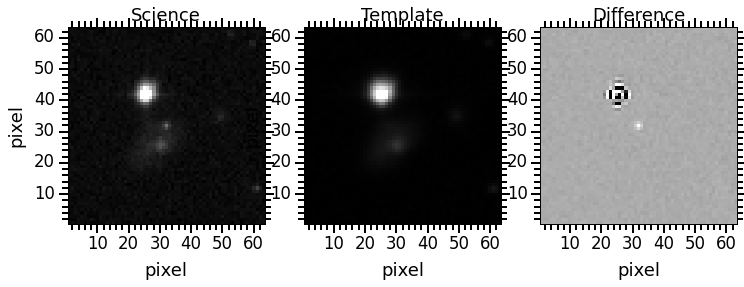

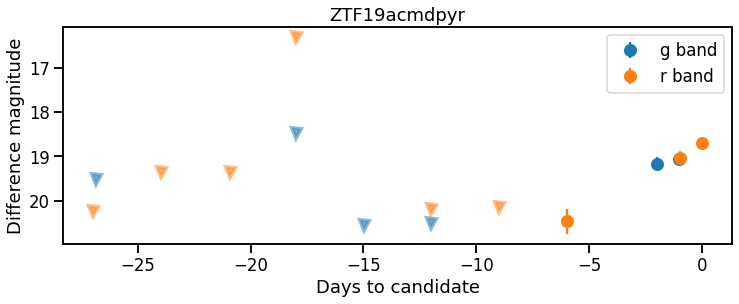

<Figure size 864x504 with 0 Axes>

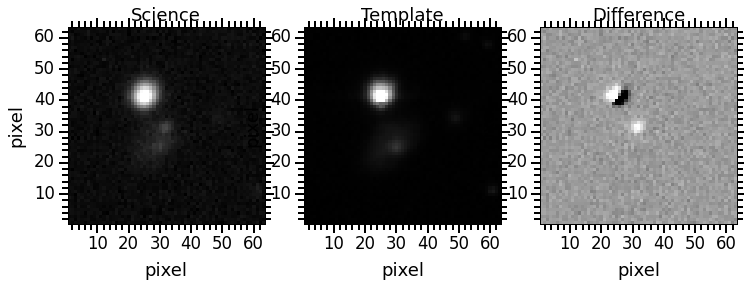

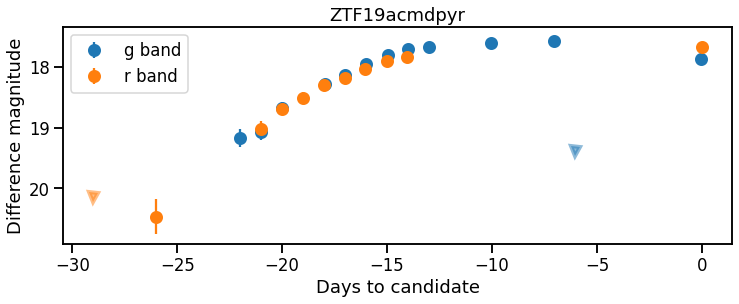

In [25]:
# to remove messages from aplpy
import logging, sys
logging.disable(sys.maxsize)

for alert in [alerts[0], alerts[-1]]:
    fig = plt.figure(figsize=(12, 7))
    plot_alert_data(alert)

Let's plot the score evolution from SuperNNova for all the alerts from this object (note there could be missing point with respect to the paper plot as I do not use points contained only in history):

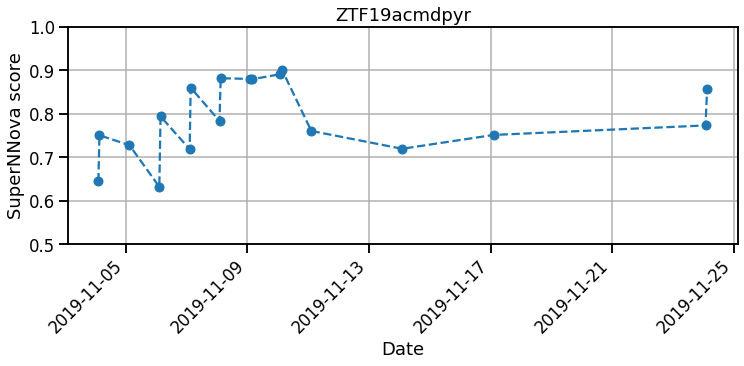

In [27]:
scores = [alert['snn_snia_vs_nonia'] for alert in alerts]
dates = [alert['timestamp'] for alert in alerts]

fig = plt.figure(figsize=(12, 4))
plt.plot(dates, scores, ls='--', marker='o')

plt.xticks(rotation=45, horizontalalignment='right')
plt.ylim(0.5, 1)
plt.grid()
plt.xlabel('Date')
plt.ylabel('SuperNNova score')
plt.title(alerts[0]['objectId']);

## Time delay between classification and SN Ia peak

An important metric is the time of 1st classification by Fink, compared to the SN Ia peak. Ideally, we want to catch the supernova before the flux peak to allow efficient follow-up. Let's compute the time delay in the case of Fink, using the current SNN module:

In [29]:
@pandas_udf("double", PandasUDFType.GROUPED_AGG)
def peakdelay(mag, jd, cmag, cjd):
    """ Very rough estimate of the delay between first
    classification date by Fink and the SN Ia peak.
    
    The search is done on the measurements (no fit).
    """
    index = np.where(mag == np.min(mag))[0][0]
    jd0 = np.min(jd)
    
    # peak is prior the detection - look at the history
    if np.min(jd) - jd.values[index] == 0:
        # Search for the history of the 1st alert
        min_jds = np.array([np.min(jd_) for jd_ in cjd])
        index = np.where(min_jds == np.min(min_jds))[0][0]
        
        # inplace replacement
        mag = np.array(cmag[index])
        jd = np.array(cjd[index])
        
        # remove upper limits
        mask = mag == mag
        
        # True SN peak!
        if len(mag[mask]) <= 1:
            return 0
        
        # search for the min mag
        index = np.where(mag[mask] == np.min(mag[mask]))[0][0]
        
        # Not enough points in the rising part
        if index < 3:
            return None
        
        # Not reached the peak yet
        if index > len(mag[mask]) - 2:
            return None

        return jd0 - jd[mask][index]
    else:
        return jd0 - jd.values[index]


df_snia = concat_col(df_snia, 'magpsf', prefix='c')
df_snia = concat_col(df_snia, 'jd', prefix='c')

df_peak = df_snia.filter(df_snia['objectId'].isin(catalog_matches.tolist()))\
    .groupBy('objectId')\
    .agg(peakdelay(df_snia['candidate.magpsf'], df_snia['candidate.jd'], df_snia['cmagpsf'], df_snia['cjd']).alias('peakdelay'))

df_peak.show(10)

pdf_peak = df_peak.toPandas()

+------------+-------------------+
|    objectId|          peakdelay|
+------------+-------------------+
|ZTF18abakunn|-1.9298379998654127|
|ZTF19abtcapa|-2.9766088002361357|
|ZTF19acjifxp|               null|
|ZTF19acjwqvo| -6.004791700281203|
|ZTF19aclkbqc|               null|
|ZTF19aclljyq|-11.866249999962747|
|ZTF19aclofmz| -13.94667820027098|
|ZTF19aclthzj|-10.858391199726611|
|ZTF19aclyezb|         -10.015625|
|ZTF19acmbiad| -3.995358800049871|
+------------+-------------------+
only showing top 10 rows



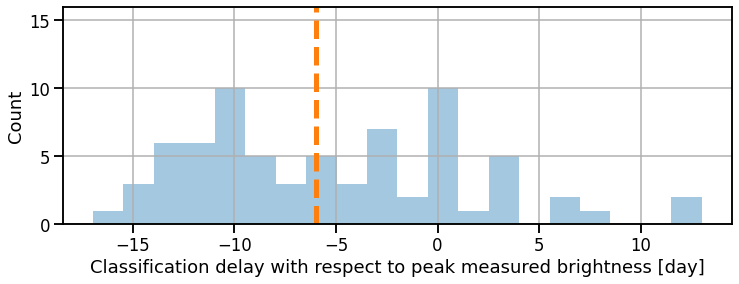

In [34]:
fig = plt.figure(figsize=(12, 4))
sns.distplot(pdf_peak.peakdelay, bins=20, kde=False)#, kde_kws={'clip': (-15, 20)})
plt.xlabel('Classification delay with respect to peak measured brightness [day]')
plt.ylabel('Count')
plt.ylim(0, 16)
plt.grid()

mask = pdf_peak.peakdelay == pdf_peak.peakdelay
plt.axvline(np.median(pdf_peak.peakdelay[mask]), ls='--', color='C1', lw=5)
plt.show()

In [35]:
print(len(pdf_peak.peakdelay[mask]))
print(np.median(pdf_peak.peakdelay[mask]))

72
-5.980011499719694


Negative delay values mean we are classifying before the SN peak! We have a large contingent of on-peak detections, and some SN seen after their peak.

## Other SN types

In this notebook, we cross-match the Fink SN Ia candidate stream with the Open Supernova Catalog (https://sne.space/). We do so for recent alerts and older ones. The idea is to characterize the candidates distributed by Fink and check the validity of the filter criteria.

In [36]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def keep_only_ztf(col):
    """Support function to highlight ZTF-only candidates"""
    if col is None:
        return ''
    elif 'ZTF' in col:
        l = [s.strip() for s in col.split(',')]
        return [s for s in l if s.startswith('ZTF')][0]
    else:
        return col

# Load the data in a Spark DataFrame
df_osc = spark.read\
    .format('csv')\
    .option('inferSchema', True)\
    .option('header', True)\
    .load('The_Open_Supernova_Catalog.csv')

# highlight candidates with ZTF ID only
df_osc = df_osc.withColumn('objectId', udf(keep_only_ztf, StringType())(df_osc['Aliases']))

df_osc_cross = df_snia.join(df_osc, 'objectId')
df_osc_cross.select(['objectId', 'Type', 'Host Name', '`Disc. Date`', 'z']).show(10)

+------------+---------+--------------------+----------+--------+
|    objectId|     Type|           Host Name|Disc. Date|       z|
+------------+---------+--------------------+----------+--------+
|ZTF19acokzjy|       Ia|                null|2019/11/04|0.065138|
|ZTF19acbhvgi|       II|                null|2019/09/25|   0.025|
|ZTF19acokfaj|Candidate|       KUG 0927+310B|2019/11/04| 0.05908|
|ZTF19actldas|       Ia|       MCG +08-12-22|2019/11/18|    0.04|
|ZTF18aatjmcx|Candidate|                null|2019/10/29|   0.063|
|ZTF19abvhduf|       Ia|                null|2019/09/01|   0.029|
|ZTF18aaheszr|Candidate|        CGCG 121-075|2018/11/03|0.032349|
|ZTF19acslqnc|Candidate|                null|2019/11/12|    null|
|ZTF19acwrujg|       Ia|                null|2019/12/02|    0.06|
|ZTF18aagpinb|       NT|2MASX J08135929+2...|2019/03/05|0.179668|
+------------+---------+--------------------+----------+--------+
only showing top 10 rows



In [37]:
df_osc_cross_grouped = df_osc_cross.groupBy('Type').count()
df_osc_cross_grouped.show()

pdf_osc_cross_grouped = df_osc_cross_grouped.toPandas()

+---------+-----+
|     Type|count|
+---------+-----+
|       Ia| 1186|
|Candidate| 2160|
|       II|  308|
|     II P|   62|
|   SLSN-I|    4|
|  Ia-99aa|    9|
|       NT|   14|
|  SLSN-II|    3|
|   Ia-91T|   36|
|      IIn|   64|
|       BL|    8|
|      IIb|    7|
|    Other|   12|
|    Ic BL|    4|
|       Ib|    3|
|       Ic|    8|
|   Ia Pec|    1|
|     null|    2|
+---------+-----+



Text(0.5, 1.0, 'Labels from the Open Supernova Catalog (per alert)')

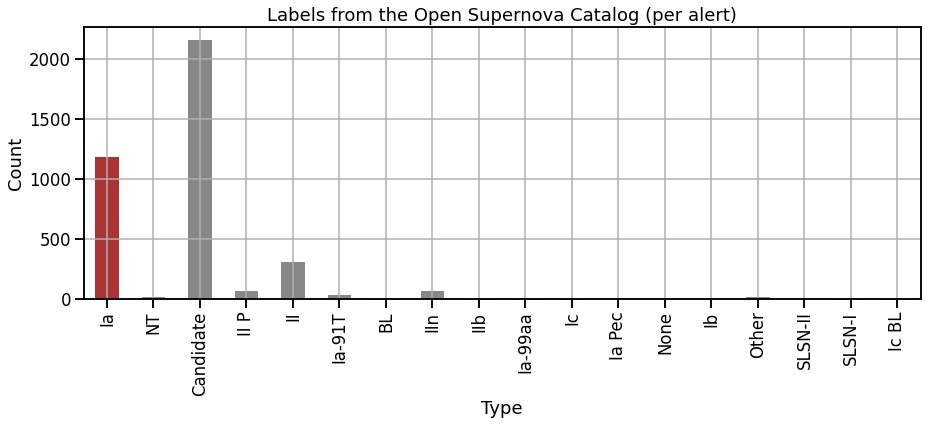

In [38]:
# Plot
pdf_osc_cross_grouped.index = pdf_osc_cross_grouped['Type']
ax = pdf_osc_cross_grouped.plot.bar(figsize=(15, 5), grid=True, color='black', legend=None)

# Highlight the Ia case
for bar in ax.patches:
    bar.set_facecolor('#888888')
highlight = 'Ia'
pos = pdf_osc_cross_grouped.index.get_loc(highlight)
ax.patches[pos].set_facecolor('#aa3333')

# label and title
plt.ylabel('Count')
plt.title("Labels from the Open Supernova Catalog (per alert)")